### Resource-Task Network (RTN)

#### Resource Balance:
$$ X_{r,t} = X_{r,t-1} + \sum_{i \in I_r} \sum_{\theta = 0}^{\tau_i} (\mu_{i,r,\theta} \cdot N_{i,t-\theta} + \nu_{i,r,\theta} \cdot \xi_{i,t-\theta}) + \Pi_{r,t} \quad \forall r \in R, t \in T$$
#### Resource Limits:
$$ X_{r}^{min} \le X_{r,t} \le X_{r}^{max} \quad \forall r \in R, t \in T$$
#### Batch Limits:
$$ V_{i}^{min} \cdot N_{i,t} \le \xi_{i,t} \le V_{i}^{max} \cdot N_{i,t} \quad \forall i \in I, t \in T$$

### System Being Modeled

#### Reaction Pathways:
1 reactor can perform three different stoichiomentric reactions (50/50 ratio for reactants):
- Reaction 1: $$ A + B \rightarrow D $$
- Reaction 2: $$ A + C \rightarrow E $$
- Reaction 3: $$ B + C \rightarrow F $$

#### Equipment:
- Storage Tanks: each material has a dedicated storage tank with a 100 L capacity.
- Reactor: The reactor can be used to produce batches that are between 30 and 60 L.

#### External material flow:
- Raw material supply arrives at t = 6, 7, 8, 9, and 10 (10 units arrive in each time period)
- External demand of products D, E, and F occurs at t = 6, 7, 8, 9, and 10 (10 units are consumed in each period0).

#### Objective:
Find the production schedule that will satisfy the external demands and require the least number of batches.

### Define the Network using NetworkX

In [2]:
# using Pkg
# Pkg.activate(".")
# Pkg.add(["JuMP","Graphs","MetaGraphs","StatsPlots","GLPK","DataFrames","GraphPlot"])

In [4]:
using Graphs, MetaGraphs, GraphPlot

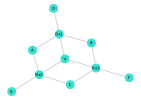

In [32]:
net = MetaGraph() #create network
set_indexing_prop!(net, :name) #indexing parameter is name
nodes = ["A","B","C","D","E","F","V","Rx1","Rx2","Rx3"] #node labels
R = ["A","B","C","D","E","F","V"] #resource nodes
Rreact = ["A","B","C"] #reactants
Rprod = ["D","E","F"] #products
I = ["Rx1","Rx2","Rx3"] #task nodes

#create nodes
for n in nodes
    add_vertex!(net, :name, n)
    if n in I
        set_props!(net, net[n,:name], Dict(
            :tau => 1, #processing time
            :Vmin => 30, #minimum batch size for each task
            :Vmax => 60 #maximum batch size for each task
        ))
    elseif n in Rreact
        set_props!(net, net[n,:name], Dict(
            :X0 => 100, #initial inventory (full reactant tanks)
            :Xmin => 0, #minimum resource level (safety stock)
            :Xmax => 100 #resource capacity 
        ))
    elseif n in Rprod
        set_props!(net, net[n,:name], Dict(
            :X0 => 0, #initial inventory (empty tanks)
            :Xmin => 0, #minimum resource level (safety stock)
            :Xmax => 100 #resource capacity 
        ))
    elseif n == "V"
        set_props!(net, net[n,:name], Dict(
            :X0 => 1, #number of reactors available initially
            :Xmin => 0, #minimum number of available reactors (busy reactor = 0 available)
            :Xmax => 1 #number of reactors
        ))
    end
end

#connect network
add_edge!(net, net["A",:name], net["Rx1",:name])
add_edge!(net, net["B",:name], net["Rx1",:name])
add_edge!(net, net["D",:name], net["Rx1",:name])

add_edge!(net, net["A",:name], net["Rx2",:name])
add_edge!(net, net["C",:name], net["Rx2",:name])
add_edge!(net, net["E",:name], net["Rx2",:name])

add_edge!(net, net["B",:name], net["Rx3",:name])
add_edge!(net, net["C",:name], net["Rx3",:name])
add_edge!(net, net["F",:name], net["Rx3",:name])

add_edge!(net, net["V",:name], net["Rx1",:name])
add_edge!(net, net["V",:name], net["Rx2",:name])
add_edge!(net, net["V",:name], net["Rx3",:name])

#add metadata to the edges
#μ is the fixed consumption/production ratio
#ν is the variable consumption/production ratio
for e in edges(net)
    src_name = get_prop(net, src(e), :name)
    if src_name in Rreact
        set_props!(net, e, Dict(
            :μ => Dict(θ => 0 for θ in 0:get_prop(net, dst(e), :tau)), #reactant consumption depends on batch size, not on task execution
            :ν => Dict(θ => θ == 0 ? -0.5 : 0 for θ in 0:get_prop(net, dst(e), :tau)) #50% of the batch size comes from each reactant when task is triggered (theta = 0) (50:50 stoichiometry); no other consumption during the reaction duration
        ))
    elseif src_name in Rprod
        set_props!(net, e, Dict(
            :μ => Dict(θ => 0 for θ in 0:get_prop(net, dst(e), :tau)), #product production depends on batch size, not on task execution
            :ν => Dict(θ => θ == get_prop(net, dst(e), :tau) ? 1 : 0 for θ in 0:get_prop(net, dst(e), :tau)) #the amount of product is the size of the batch (100% conversion) when theta = tau; no amount of product is produced before the reaction ends (no material is drained during task execution)
        ))
    elseif src_name == "V"
        set_props!(net, e, Dict(
            :μ => Dict(
                θ => 
                    θ == 0 ? -1 : #when a reaction is triggered (theta = 0), 1 reactor is consumed
                    θ == get_prop(net, dst(e), :tau) ? 1 : #when the reaction completes (theta = tau), 1 reactor is regenerated
                    0 #no consumption/production of reactors in the intermediate timepoints of the reaction duration
                for θ in 0:get_prop(net, dst(e), :tau)
            ), #product production depends on batch size, not on task execution
            :ν => Dict(θ => 0 for θ in 0:get_prop(net, dst(e), :tau)) #consumption/production of reactant not goverened by batch sizes
        ))
    end
end

gplot(net, nodelabel = nodes)

### Define the MILP model for the RTN

In [7]:
using JuMP, GLPK

In [45]:
horizon = 10
RTN = Model(GLPK.Optimizer)

#define sets
T = 0:horizon #time points
T1 = 1:horizon #exclude time point 0, which is only for initialization
Ir = Dict(r => [net[j,:name] for j in neighbors(net, net[r,:name])] for r in R) #tasks associated with each resource r
Ri = Dict(i => [net[j,:name] for j in neighbors(net, net[i,:name])] for i in I) #resources associated with task i

#define parameters
max_tau = maximum([get_prop(net, net[i,:name], :tau) for i in I]) #maximum tau in the system
@expression(RTN, #tau (task durations)
    tau[i in I],
    get_prop(net, net[i,:name], :tau)
)
@expression(RTN, #μ parameter
    μ[i in I, r in Ri[i], θ in 0:tau[i]], 
    get_prop(net, net[i,:name], net[r,:name], :μ)[θ]
)
@expression(RTN, #ν parameter
    ν[i in I, r in Ri[i], θ in 0:tau[i]], 
    get_prop(net, net[i,:name], net[r,:name], :ν)[θ]
)
@expression(RTN, #Vmax (max batch size)
    Vmax[i in I],
    get_prop(net, net[i,:name], :Vmax)
)
@expression(RTN, #Vmin (min batch size)
    Vmin[i in I],
    get_prop(net, net[i,:name], :Vmin)
)
@expression(RTN, #X0 (initial resource inventory)
    X0[r in R],
    get_prop(net, net[r,:name], :X0)
)
@expression(RTN, #Xmax (maximum resource inventory)
    Xmax[r in R],
    get_prop(net, net[r,:name], :Xmax)
)
@expression(RTN, #Xmin (minimum resource inventory)
    Xmin[r in R],
    get_prop(net, net[r,:name], :Xmin)
)
@expression(RTN,
    Π[r in R, t in T1],
    r in Rprod && t > horizon/2 ? -10 : #the demand (exit) for products is 50 units at t = horizon
    r in Rreact && t > horizon/2 ? 10 : #receive (entrance) 10 units of raw materials for the second half of the timeline
    0 #otherwise
)

#variables
@variable(RTN, Xmin[r] ≤ X[r in R, t in T] ≤ Xmax[r]) #resource inventory level
for r in R #set initial inventory levels
    fix(X[r,0], X0[r]; force=true) 
end
@variable(RTN, N[i in I, t in T1], Bin) #task triggering
@variable(RTN, 0 ≤ ξ[i in I, t in T1]) #task batch size

#constraints
@constraint(RTN, Balance[r in R, t in T1],
    X[r,t] == 
        X[r,t-1] 
        + ∑(
            μ[i,r,θ] * N[i,t-θ] 
            + ν[i,r,θ] * ξ[i,t-θ] 
            for i in Ir[r], θ in 0:max_tau if θ ≤ tau[i] && t-θ ≥ 1
        ) 
        + Π[r,t]
)
@constraint(RTN, ResourceLB[r in R, t in T1],
    Xmin[r] ≤ X[r,t]
)
@constraint(RTN, ResourceUB[r in R, t in T1],
    X[r,t] ≤ Xmax[r]
)
@constraint(RTN, BatchLB[i in I, t in T1],
    Vmin[i] * N[i,t] ≤ ξ[i,t]
)
@constraint(RTN, BatchUB[i in I, t in T1],
    ξ[i,t] ≤ Vmax[i] * N[i,t]
)

#objective
@objective(RTN, 
    Min,
    ∑(N[i,t] for i in I, t in T1)
)

#solve
set_optimizer_attribute(RTN, "msg_lev", GLPK.GLP_MSG_ALL)
optimize!(RTN)

GLPK Simplex Optimizer 5.0
270 rows, 137 columns, 544 non-zeros
      0: obj =  0.000000000e+000 inf =  6.010e+002 (34)
     91: obj =  4.333333333e+000 inf =  0.000e+000 (0)
*   112: obj =  2.500000000e+000 inf =  1.236e-013 (0)
OPTIMAL LP SOLUTION FOUND
GLPK Integer Optimizer 5.0
270 rows, 137 columns, 544 non-zeros
30 integer variables, all of which are binary
Integer optimization begins...
Long-step dual simplex will be used
+   112: mip =     not found yet >=              -inf        (1; 0)
+   153: >>>>>  4.000000000e+000 >=  3.000000000e+000  25.0% (24; 1)
+   186: >>>>>  3.000000000e+000 >=  3.000000000e+000   0.0% (9; 36)
+   186: mip =  3.000000000e+000 >=     tree is empty   0.0% (0; 59)
INTEGER OPTIMAL SOLUTION FOUND


### Plot the results

In [73]:
using DataFrames, StatsPlots
X = value.(RTN[:X]) #get resource levels
ξ = value.(RTN[:ξ]) #get batch sizes
resources = DataFrame([r => X[r,:].data for r in R]...)
resources.time = T
tanks = select(resources, Not("V"))
reactor = select(resources, "time", "V")
batches = DataFrame([i => ξ[i,:].data for i in I]...);
batches.time = T1

1:10

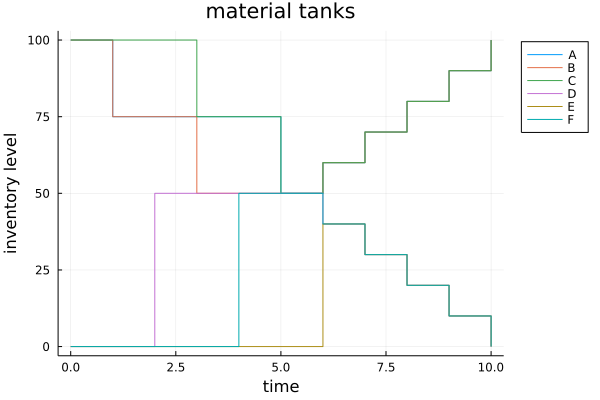

In [72]:
@df stack(tanks, Not(:time)) plot(:time, :value, group=:variable, title="material tanks", xlabel="time", ylabel="inventory level", linetype = :steppost, legend=:outertopright)

### Observations:
The system builds inventory in the first three time periods so that it has enough to meet the demand in the last 4 periods.

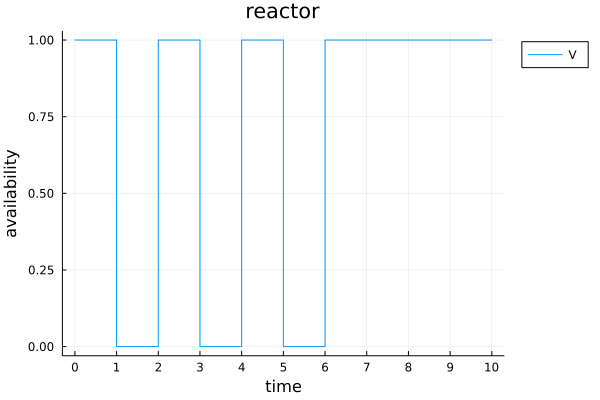

In [76]:
@df stack(reactor, Not(:time)) plot(:time, :value, group=:variable, title="reactor", xlabel="time", ylabel="availability", linetype = :steppost, legend=:outertopright, xticks=T)

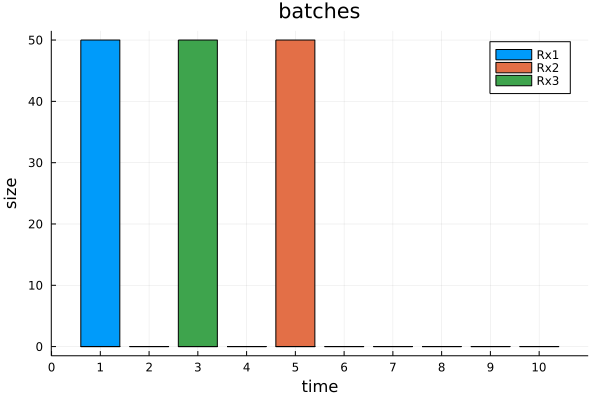

In [79]:
@df stack(batches, Not(:time)) bar(:time, :value, group=:variable, title="batches", xlabel="time", ylabel="size", xticks=T)

### Observations:
The reactor is used three times at t = 1, 3, 5. Since the objective penalizes for the number of times a reaction is triggered, the reactor is used only once for each material since its production capacity allows it.